In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fmin
import matplotlib.pyplot as plt

In [3]:
'''

Define useful functions


'''

def stress_intensity(L,sigma):
    return sigma*np.sqrt(np.pi*L)

def find_min_rxx(L,sigma0,K_ic):
    # Find Rxx such that K_i = K_ic assuming no dynamic contribution from water level
    goal = lambda R : np.abs(K_ic - stress_intensity(L0,R+sigma0))
    Rxx_best = fmin(goal, 10e3)
    return Rxx_best

Optimization terminated successfully.
         Current function value: 0.000053
         Iterations: 42
         Function evaluations: 84
Mean crack propagation rate (epsilon=40): 1353.89  m/s
Mean crack propagation rate (epsilon=40): 1353.89  m/s


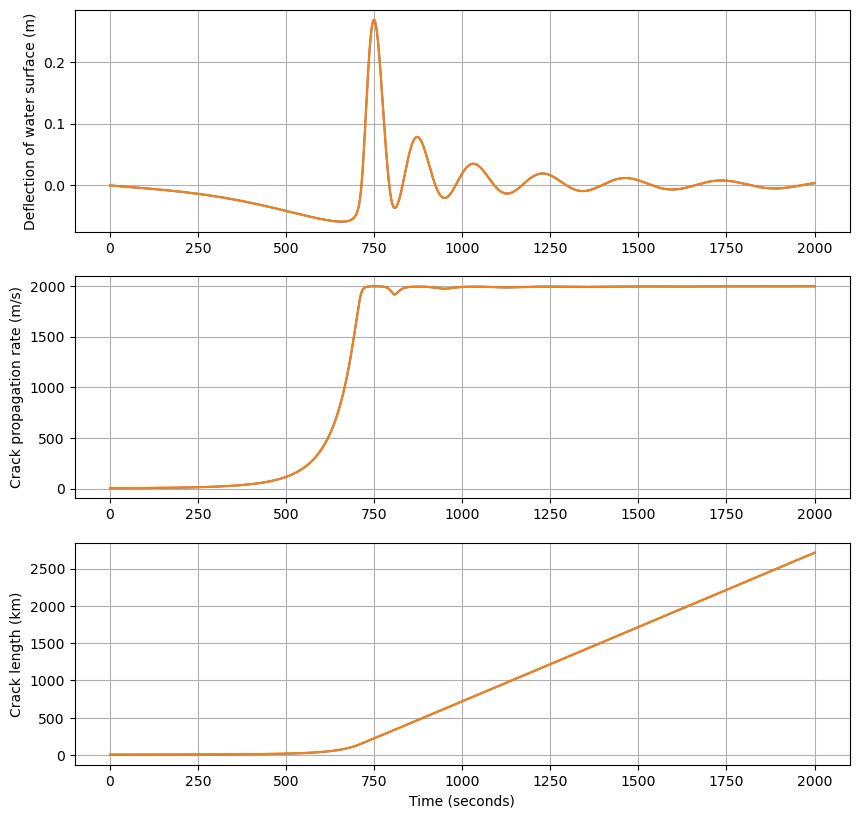

In [12]:
'''

Define model

'''

# this version includes nonzero initial width and accounts for alpha's dependence on time
def water_crack(y, t, epsilon, H_i, Rxx, w0):
    
    # get variables and set parameters
    eta, d_eta_dt, L = y
    g = 9.8
    v_r = 2000
    K_c = 1e5
    rho_i = 910
    rho_w = 1000
    H_w = rho_i/rho_w * H_i


    # calculate stress and stress intensity factor
    sigma = rho_i*g*H_i/2 - rho_w*g/(2*H_i)*eta**2
    sigma_sum = Rxx - sigma
    K_i = stress_intensity(L,sigma_sum)
    
    # use stress intensity factor to determine if crack propagates
    if K_i < K_c:
        dLdt = 0
    else:
        dLdt = v_r * (1 - (K_c/K_i)**2)
        
    # use "Eshelby" relation to get width and its time derivative as a function of length
    mu_star = 3.6e9/(1-0.33)
    alpha = sigma_sum / mu_star * np.pi/4
    w = w0 + alpha * L

    # write time derivative of stress sum
    d_sigma_sum_dt = d_eta_dt*eta*rho_w*g/H_i
    
    # write time derivative of alpha
    d_alpha_dt = d_sigma_sum_dt*np.pi/mu_star/4
    
    # write time derivative of width
    dwdt = alpha*dLdt + d_alpha_dt*L
        
    # write time derivative of water volume, V'
    dVdt = w*L*d_eta_dt + w*dLdt*eta + dwdt*L*eta

    # write 2nd time derivative of crack length
    dLd2t = (v_r*K_c**2)/np.pi * (1/((L**2)*(sigma_sum**3))*(dLdt*sigma_sum + 2*L*d_sigma_sum_dt))
    
    # write expression for terms of V" that do not contain eta"
    gamma = rho_w*g*np.pi/4/H_i/mu_star
    lamb = 2*(w*dLdt*d_eta_dt + dwdt*L*d_eta_dt + dwdt*dLdt*eta) + w*dLd2t*eta + L*eta*(alpha*dLd2t + 2*d_alpha_dt*dLdt + gamma*L*d_eta_dt**2)
    beta = L*(w + gamma*L*eta**2)
    
    # write bernoulli with u' substituted in so all eta" terms can be moved to LHS
    d_eta_d2t = (H_w + epsilon*beta/L)**-1 * (g*(H_w - eta) - (epsilon/L**2)*(lamb*L - dVdt*dLdt))
    
    dydt = [d_eta_dt, d_eta_d2t, dLdt]
    
    return dydt


'''

Define parameters

'''

H_i = 200
rho_i = 910
rho_w = 1000
H_w = rho_i/rho_w * H_i
g = 9.8
eta0 = H_w
d_eta_dt0 = 0
L0 = 5e3
w0 = 2
K_ic = 1e5
sigma0 = -rho_i*g*H_i/2 + rho_w*g/(2*H_i)*eta0**2

# The following calculates Rxx such that K_ic = K_i, and then adds a tiny perturbation
Rxx = find_min_rxx(L0,sigma0,K_ic)[0]+1



'''

Run simulations

'''

y0 = [eta0, d_eta_dt0,L0]
t = np.linspace(0, 2000, 10001)
fig,ax=plt.subplots(3,1,figsize=(10,10),dpi=100)
fig.patch.set_facecolor('w')

for epsilon in (40,40):

    sol = odeint(water_crack, y0, t, args=(epsilon, H_i, Rxx, w0))

    ax[0].plot(t, sol[:, 0]-H_w)
    ax[0].set_ylabel('Deflection of water surface (m)')
    ax[1].plot(t, np.gradient(sol[:, 2],t), label='L(t), km')
    ax[1].set_ylabel('Crack propagation rate (m/s)')
    ax[2].plot(t, sol[:, 2]/1e3, label='L(t), km')
    ax[2].set_ylabel('Crack length (km)')
    print("Mean crack propagation rate (epsilon="+str(epsilon)+"):",np.round(np.mean(np.gradient(sol[:, 2],t)),2)," m/s")
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.xlabel('Time (seconds)')
plt.show()

In [200]:
'''

Use dispersion relation to calculate resonant frequencies

'''

def dispersion(xi,H_i):
    g = 9.8
    rho_i = 910
    rho_w = 1024
    H_w = H_i * rho_i / rho_w 
    E = 8.7e9
    nu = 0.3
    D = (E * H_i**3) / (12*(1-nu**2))
    gamma = 1/np.tanh(H_w*xi)/xi;
    omega = np.sqrt((D*xi**4 + rho_w*g)/(rho_i*H_i + rho_w*gamma))
    return omega 

def resonance(L,H_i,mode):
    xi = (mode+1)*np.pi/L
    omega = dispersion(xi,H_i)
    t = 2*np.pi/omega
    return t

# set parameters
L = 30000
H_i = 750

# first 3 modes
mode_1_period = resonance(L,H_i,0)
mode_2_period = resonance(L,H_i,1)
mode_3_period = resonance(L,H_i,2)
print(mode_1_period)
print(mode_2_period)
print(mode_3_period)

743.3096327516084
364.42923762240997
221.07039351237157
